In [1]:
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

zips_gdf = gpd.read_file(f'{EXPORTS_DIR}/zips_bk.shp').to_crs({'init': CRS_PLOT})
lion_nodes_gdf = gpd.read_file(f'{DATA_DIR}/lion_nodes_bk.geojson').to_crs({'init': CRS_PLOT})
edges_df = pd.read_csv(f'{EXPORTS_DIR}/edges_bk.csv')
edges_df['nodes_to'] = edges_df['nodes_to'].apply(lambda x: eval(x))

In [3]:
edges_df['size'] = edges_df['nodes_to'].apply(lambda x: len(x))
edges_df = edges_df.sort_values(by=['size', 'node_from'], ascending=[True, True])
edges_df.head()

,node_from,nodes_to,size
26785,11360,{9018983},1
25398,11362,{11363},1
26148,11365,{11371},1
1590,11366,{11368},1
25417,11367,{11370},1


In [4]:
nodes_set = set()
for i in range(0, len(edges_df)):
    node_id = edges_df.iloc[i, 0]
    nodes_set.add(node_id)
    
for i in range(0, len(edges_df)):
    node_id = edges_df.iloc[i, 0]
    nodes_set.add(node_id)

In [5]:
class Node:
    def __init__(self, id):
        self.id = id
        self.edges = set()
        row = lion_nodes_gdf[lion_nodes_gdf['NODEID'] == id]
        
        self.lat = list(row.geometry)[0][0].y
        self.lon = list(row.geometry)[0][0].x
        
        self.point = Point(self.lon, self.lat)
        
    def add_neighbor(self, node):
        edge = Edge(self, node)
        self.edges.add(edge)
        return edge
        
class Edge:
    def __init__(self, node_from, node_to):
        self.node_from = node_from
        self.node_to = node_to
        self.key = f'{node_from.id}:{node_to.id}'
        self.line_string = LineString([node_from.point, node_to.point])

In [6]:
nodes_dict = {}

for i in range(0, len(edges_df)):
    node_id = edges_df.iloc[i, 0]
    nodes_dict[node_id] = Node(node_id)

In [7]:
edges_dict = {}

for i in range(0, len(edges_df)):
    node_id = edges_df.iloc[i, 0]
    neighbor_ids = edges_df.iloc[i, 1]
    for neighbor_id in neighbor_ids:
        if neighbor_id in nodes_dict:
            edge = nodes_dict[node_id].add_neighbor(nodes_dict[neighbor_id])
            edges_dict[edge.key] = edge

In [8]:
trajectory_df = pd.read_csv(f'{EXPORTS_DIR}/b25_7131.csv')
trajectory_gdf = gpd.GeoDataFrame(trajectory_df, geometry=gpd.points_from_xy(trajectory_df['longitude'], trajectory_df['latitude']), crs=CRS_PLOT)
trajectory_gdf.head()

,route,x,latitude,longitude,bus_id,datetime,geometry,bus_lane
0,MTA NYCT_B25,0,40.686127,-73.974083,MTA NYCT_7131,Thu Jun 03 23:46:12 CST 2021,POINT (-73.97408 40.68613),True
1,MTA NYCT_B25,0,40.685387,-73.972145,MTA NYCT_7131,Thu Jun 03 23:46:43 CST 2021,POINT (-73.97215 40.68539),True
2,MTA NYCT_B25,0,40.683743,-73.968063,MTA NYCT_7131,Thu Jun 03 23:48:16 CST 2021,POINT (-73.96806 40.68374),True
3,MTA NYCT_B25,0,40.682816,-73.963799,MTA NYCT_7131,Thu Jun 03 23:50:37 CST 2021,POINT (-73.96380 40.68282),True
4,MTA NYCT_B25,0,40.682163,-73.960648,MTA NYCT_7131,Thu Jun 03 23:52:08 CST 2021,POINT (-73.96065 40.68216),False


In [9]:
def is_on_line(p, line):
    nearest_point = line.interpolate(line.project(p))
    return nearest_point.distance(p) < 0.0001

edges = list(edges_dict.values())
lines = [e.line_string for e in edges_dict.values()]
lines_gs = gpd.GeoSeries(lines, crs=CRS_PLOT).to_crs(CRS_PLOT)

In [10]:
trajectory_gdf.iloc[18:22, :]

,route,x,latitude,longitude,bus_id,datetime,geometry,bus_lane
18,MTA NYCT_B25,0,40.678158,-73.908577,MTA NYCT_7131,Fri Jun 04 00:18:20 CST 2021,POINT (-73.90858 40.67816),False
19,MTA NYCT_B25,0,40.677876,-73.903618,MTA NYCT_7131,Fri Jun 04 00:20:23 CST 2021,POINT (-73.90362 40.67788),False
20,MTA NYCT_B25,0,40.677181,-73.901176,MTA NYCT_7131,Fri Jun 04 00:22:32 CST 2021,POINT (-73.90118 40.67718),False
21,MTA NYCT_B25,0,40.676769,-73.900154,MTA NYCT_7131,Fri Jun 04 00:23:34 CST 2021,POINT (-73.90015 40.67677),False


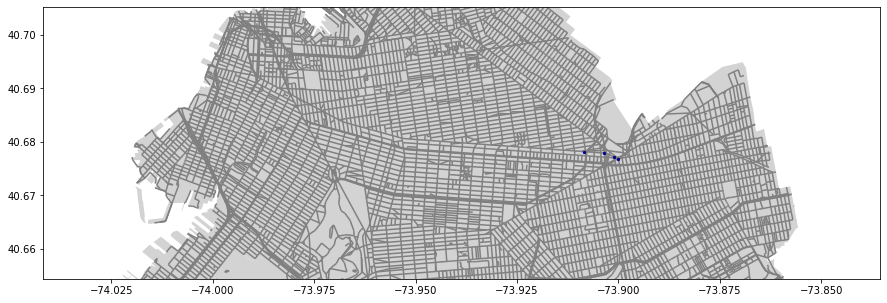

In [11]:
def crop(gdf, ax, x_bounds, y_bounds):
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    dx = maxx - minx
    dy = maxy - miny
    ax.set_xlim(minx + x_bounds[0] * dx, minx + x_bounds[1] * dx)
    ax.set_ylim(maxy - y_bounds[1] * dy, maxy - y_bounds[0] * dy)

fig, ax = plt.subplots(figsize=(15, 15))
crop(zips_gdf, ax, [0.0, 1.0], [0.2, 0.5])

zips_gdf.plot(ax=ax, color='lightgrey')
lines_gs.plot(ax=ax, color='grey')
trajectory_gdf.iloc[18:22, :].plot(ax=ax, color='darkblue', markersize=5, zorder=2)

plt.show()

In [12]:
point_gdf = trajectory_gdf.iloc[10:11, :]
point_gdf

,route,x,latitude,longitude,bus_id,datetime,geometry,bus_lane
10,MTA NYCT_B25,0,40.679771,-73.938728,MTA NYCT_7131,Fri Jun 04 00:03:30 CST 2021,POINT (-73.93873 40.67977),False


In [13]:
trajectory_gdf['datetime'] = pd.to_datetime(trajectory_gdf['datetime'])

In [14]:
from datetime import timedelta

i = 0
while i < len(trajectory_gdf) - 1:
    curr_dt = trajectory_gdf.loc[i, 'datetime']
    next_dt = trajectory_gdf.loc[i + 1, 'datetime']
    if next_dt - curr_dt > timedelta(minutes=30):
        break
    i += 1

trajectory1_gdf = trajectory_gdf.iloc[0:i+1, :]
trajectory1_gdf

,route,x,latitude,longitude,bus_id,datetime,geometry,bus_lane
0,MTA NYCT_B25,0,40.686127,-73.974083,MTA NYCT_7131,2021-06-03 23:46:12,POINT (-73.97408 40.68613),True
1,MTA NYCT_B25,0,40.685387,-73.972145,MTA NYCT_7131,2021-06-03 23:46:43,POINT (-73.97215 40.68539),True
2,MTA NYCT_B25,0,40.683743,-73.968063,MTA NYCT_7131,2021-06-03 23:48:16,POINT (-73.96806 40.68374),True
3,MTA NYCT_B25,0,40.682816,-73.963799,MTA NYCT_7131,2021-06-03 23:50:37,POINT (-73.96380 40.68282),True
4,MTA NYCT_B25,0,40.682163,-73.960648,MTA NYCT_7131,2021-06-03 23:52:08,POINT (-73.96065 40.68216),False
5,MTA NYCT_B25,0,40.681061,-73.955376,MTA NYCT_7131,2021-06-03 23:54:09,POINT (-73.95538 40.68106),False
6,MTA NYCT_B25,0,40.680534,-73.952400,MTA NYCT_7131,2021-06-03 23:56:11,POINT (-73.95240 40.68053),False
7,MTA NYCT_B25,0,40.680370,-73.949371,MTA NYCT_7131,2021-06-03 23:57:42,POINT (-73.94937 40.68037),False
8,MTA NYCT_B25,0,40.680336,-73.948692,MTA NYCT_7131,2021-06-03 23:59:14,POINT (-73.94869 40.68034),False
9,MTA NYCT_B25,0,40.679996,-73.942635,MTA NYCT_7131,2021-06-04 00:01:56,POINT (-73.94263 40.68000),False


In [15]:
def get_min_distance(p, line):
    nearest_point = line.interpolate(line.project(p))
    return nearest_point.distance(p)

def get_nearest_edge(point):
    nearest_edge = edges[0]
    nearest_dist = 1
    for edge in edges:
        dist = get_min_distance(point, edge.line_string)
        if dist < nearest_dist:
            nearest_dist = dist
            nearest_edge = edge
    return nearest_edge

THRESHOLD = 0.0001
nearest_edges = []
for i in range(0, len(trajectory1_gdf)):
    point_row = trajectory1_gdf.iloc[i]
    point = Point(point_row.geometry.x, point_row.geometry.y)
    nearest_edges.append(get_nearest_edge(point))
    
display(trajectory1_gdf.head())

,route,x,latitude,longitude,bus_id,datetime,geometry,bus_lane
0,MTA NYCT_B25,0,40.686127,-73.974083,MTA NYCT_7131,2021-06-03 23:46:12,POINT (-73.97408 40.68613),True
1,MTA NYCT_B25,0,40.685387,-73.972145,MTA NYCT_7131,2021-06-03 23:46:43,POINT (-73.97215 40.68539),True
2,MTA NYCT_B25,0,40.683743,-73.968063,MTA NYCT_7131,2021-06-03 23:48:16,POINT (-73.96806 40.68374),True
3,MTA NYCT_B25,0,40.682816,-73.963799,MTA NYCT_7131,2021-06-03 23:50:37,POINT (-73.96380 40.68282),True
4,MTA NYCT_B25,0,40.682163,-73.960648,MTA NYCT_7131,2021-06-03 23:52:08,POINT (-73.96065 40.68216),False


In [16]:
nearest_edges_gs = gpd.GeoSeries([e.line_string for e in nearest_edges], crs=CRS_PLOT).to_crs(CRS_PLOT)

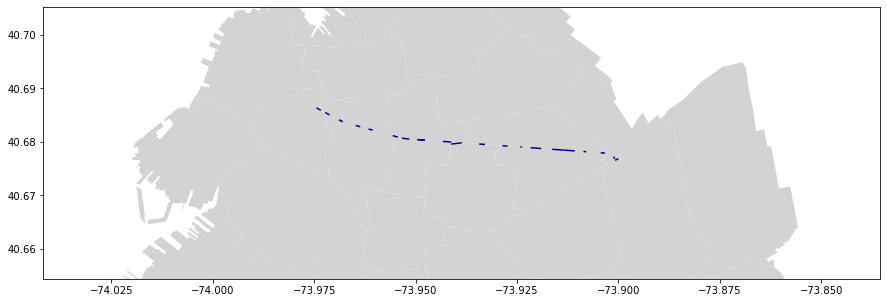

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
crop(zips_gdf, ax, [0.45, 0.55], [0.3, 0.4])
crop(zips_gdf, ax, [0.0, 1.0], [0.2, 0.5])
zips_gdf.plot(ax=ax, color='lightgrey')
nearest_edges_gs.plot(ax=ax, color='darkblue')
plt.show()

In [18]:
def dedup(item_list):
    item_set = set()
    items = []
    for item in item_list:
        if item in item_set:
            continue
        item_set.add(item)
        items.append(item)
    return items

nearest_edges_set = dedup(nearest_edges)

In [19]:
class Path:
    def __init__(self, edge, path=None):
        self.edges = deque([])
        if path != None:
            self.edges = path.edges.copy()
        self.edges.append(edge)
        
    def get_neighbors(self):
        neighbor_edges = self.get_end().edges
        return [Path(edge, path=self) for edge in neighbor_edges]
        
    def get_end(self):
        return self.edges[-1].node_to

all_edges = []
def bfs(edge1, edge2):
    source = edge1.node_from
    target = edge2.node_to
    
    queue = deque()
    node = source
    edges = source.edges
    path = Path(edge1)
    paths = [Path(e, path=path) for e in edges]
    queue.extend(paths)
    visited = set([source])
    
    all_edges.extend(edges)
    
#    print('source: ', source.point)
    
    while len(queue) > 0:
        path = queue.popleft()
        node = path.get_end()
        #print(node.point)
        
        if node in visited:
            continue
        if node == target:
            print('Found target')
            return path
        if len(queue) > 100:
            print('Exceeded limit')
            print(edge1)
            print(edge2)
            break
        visited.add(node)
        
        all_edges.extend(node.edges)
        next_paths = path.get_neighbors()
        queue.extend(next_paths)
    print('queue empty', len(queue))
        
#    print('target: ', target.point)

trajectory_edges = []
for i in range(0, len(nearest_edges_set) - 1):
    source_edge = nearest_edges_set[i]
    target_edge = nearest_edges_set[i + 1]
    
    path = bfs(source_edge, target_edge)
    if path == None:
        print(i)

    for edge in path.edges:
        trajectory_edges.append(edge)
    
trajectory_edges = dedup(trajectory_edges)

i = 9

Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target
Found target


In [20]:
def get_point_at(gdf, index):
    row = gdf.iloc[index]
    return Point(row.geometry.x, row.geometry.y)

point1 = get_point_at(trajectory1_gdf, 9)
point2 = get_point_at(trajectory1_gdf, 10)

edge1 = get_nearest_edge(point1)
edge2 = get_nearest_edge(point2)

edge1_gs = gpd.GeoSeries([edge1.line_string], crs=CRS_PLOT).to_crs(CRS_PLOT)
edge2_gs = gpd.GeoSeries([edge2.line_string], crs=CRS_PLOT).to_crs(CRS_PLOT)

path_edges_gs = gpd.GeoSeries([e.line_string for e in path.edges], crs=CRS_PLOT).to_crs(CRS_PLOT)
trajectory_edges_gs = gpd.GeoSeries([e.line_string for e in trajectory_edges], crs=CRS_PLOT).to_crs(CRS_PLOT)

In [21]:
for e in path.edges:
    print(e.key)

102918:29242
102918:9036160
9036160:29249
29249:79848
79848:29244
29244:80231


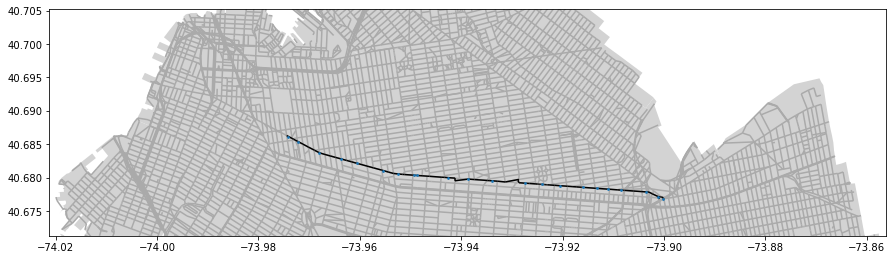

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
crop(zips_gdf, ax, [0.1, 0.9], [0.2, 0.4])
zips_gdf.plot(ax=ax, color='lightgrey')
lines_gs.plot(ax=ax, color='#aaa')
#all_edges_gs.plot(ax=ax, color='darkgrey')
trajectory_edges_gs.plot(ax=ax, color='black')
#path_edges_gs.plot(ax=ax, color='orange')
trajectory1_gdf.plot(ax=ax, zorder=2, markersize=3)

# split 10-11

#edge1_gs.plot(ax=ax, color='darkblue')
#edge2_gs.plot(ax=ax, color='darkred')

#ax.scatter(point1.x, point1.y, color='blue')
#ax.scatter(point2.x, point2.y, color='red')

plt.show()

In [23]:
print(nearest_edges_set[9].key)
print(nearest_edges_set[10].key)

9057822:9057821
26818:26824
